# Visualize Predictions, Precision/Recall Curves, Training Loss

In [1]:
# visualize() renders predictions of crops/images
# stores them under models/<S@N@A@RES>/<modelseries name>/playground/<checkpoint>/<conf_tresh>

import torch
import torchvision.models as models
import model as m
import dataset as d
import eval
import util
import config as c
import ModelSeries as ms
from importlib import reload
import os
reload(eval)
reload(util)
reload(d)
reload(m)
reload(ms)

def visualize(gt_df, series, conf_thr = 0.1):
    eval_dataset = d.CroppedDataset(gt_df, mode = "val")
    print(f"debug visualize: len(eval_dataset): {len(eval_dataset)}")
    series.model.eval()
    series.model.to("cuda")

    
    dir = os.path.join(series.series_dir, "playground", f"{series.getEpoch()}")
    os.makedirs(dir, exist_ok=True)

    for i in range(20):
        idx = i * 200
        try:
            image, target = eval_dataset[idx % len(eval_dataset)]
            image, target = image.to("cuda"), target.to("cuda")
        except Exception:
            print("error loading the image")
            print(f"type image, target: {type(image), type(target)}")
            continue
        

        with torch.no_grad():
            pred = series.model(image.unsqueeze(0))  # [1, 1, H, W] -> model -> [1, N, N, A, 5+C]
            pred = pred.squeeze(0)  # [N, N, A, 5+C]

        pred = eval.logit_to_target(pred)

        iou = eval.pred_to_iou(pred, target)
        tp_mask, fp_mask, fn_mask, tgt_conf, pred_cls, tgt_cls = eval.calc_masks(pred, target, iou, conf_thr=conf_thr)
        precision, recall = eval.unit_precision_recall(tp_mask, fp_mask, fn_mask)
        

        prec = f"{precision:.4f}"
        rec = f"{recall:.4f}"
        util.render_prediction(image, pred, iou, out_dir = os.path.join(dir, f"{conf_thr}"), name = f"crop_{i}_{prec}_{rec}.png", obj_thresh=conf_thr)
    print(f"Visualization saved to {dir}")

In [ ]:
import numpy as np
from IPython.display import display
reload(util)
gt_df = util.DataExtractor().croppedData()
def demo(series, filepath, conf_thr=0.1):
    series.model.eval().to("cpu")

    demo_dir = os.path.join(os.getcwd(), "demo")
    img_path = os.path.join(demo_dir, filepath)
    if not os.path.isfile(img_path):
        print(f"File NOT found: {img_path}")
        return
    print(f"Found file: {img_path}  ({os.path.getsize(img_path)} bytes)")

    try:
        # unpack tuple from util.load_crop_image
        crop_img, *_ = util.load_crop_image(img_path, 0, 0)  # PIL Image
        # force grayscale, (H,W)
        arr = np.array(crop_img.convert("L"), dtype=np.float32) / 255.0
        # -> (1,1,H,W)
        image = torch.from_numpy(arr).unsqueeze(0).unsqueeze(0).to("cpu")
        print("image.shape:", tuple(image.shape))
    except Exception as e:
        print("error loading the image:", repr(e))
        return

    with torch.no_grad():
        pred = series.model(image)         # (1,N,N,A,5+C)
        pred = pred.squeeze(0)             # (N,N,A,5+C)
        pred = eval.logit_to_target(pred)  # decode to (tx,ty,tw,th,obj,...)

    out_dir = os.path.join(demo_dir, "preds")
    os.makedirs(out_dir, exist_ok=True)

    # render expects (H,W) or (1,H,W); give it (H,W)
    util.render_prediction(
        image=image.squeeze(0).squeeze(0).to("cpu"),
        pred=pred.to("cpu"),
        obj_thresh=conf_thr,
        out_dir=out_dir,
        name=os.path.basename(filepath).replace(".", f"_thr{conf_thr}.")
    )
    print(f"Saved visualization → {out_dir}")
    
series = ms.ModelSeries(name = "runpod_oneshot_training2", gt_df = gt_df, mode="")
demo(series, r"images\aug-emmentaler.png", conf_thr=0.1)

Saving to: c:\Users\alexh\Desktop\ComputerVision\Hausarbeit\obb_anns_hausarbeit\ds2_dense\ds2_dense\gt_space.json
ModelSeries: loadJsonData()
Found file: c:\Users\alexh\Desktop\ComputerVision\Hausarbeit\obb_anns_hausarbeit\demo\images\aug-emmentaler.png  (381600 bytes)
image.shape: (1, 1, 720, 720)


TypeError: render_prediction() got an unexpected keyword argument 'pred'

In [23]:
import ModelSeries as ms
de = util.DataExtractor()
gt_df = de.croppedData()

eval_dataset = d.CroppedDataset(gt_df, mode = "val")
series = ms.ModelSeries(name = "runpod_oneshot_training2", gt_df = gt_df, mode = "training")

visualize(gt_df, series, conf_thr = 0.07)

Saving to: /workspace/mydir/obb_anns_hausarbeit/ds2_dense/ds2_dense/gt_space.json
val-dataset created containing 136 crops
ModelSeries: loadJsonData()
lateset checkpoint: 219.pth
[loadMode] Loaded weights from /workspace/mydir/obb_anns_hausarbeit/models/60@60@2@720/runpod_oneshot_training2/checkpoints/219.pth
val-dataset created containing 136 crops
debug visualize: len(eval_dataset): 136
Visualization saved to /workspace/mydir/obb_anns_hausarbeit/models/60@60@2@720/runpod_oneshot_training2/playground/223


# Precision and Recall

In [19]:
import eval
import ModelSeries as ms
from importlib import reload
reload(eval)
series = ms.ModelSeries(name = "train_with_lr1e-2_tryC", mode = "training")

threshs = [0.015, 0.01625, 0.0175, 0.01875, 0.02, 0.04, 0.06, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

pr_curve = []
pr2_curve = []
print("h")
for i in threshs:
    pr_curve.append(eval.avg_precision_recall(series.model, eval_dataset, "cuda", n_samples=100, conf_thr= i ))#mit 200 und len(thresh)=16 dauerts 12 Minuten
    


ModelSeries: loadJsonData()
[loadMode] Loaded weights from c:\Users\alexh\Desktop\cv3\obb_anns_hausarbeit\models\60@20@2@480\train_with_lr1e-2_tryC\checkpoints\57.pth
h
avg_precision called


c:\Users\alexh\Desktop\cv3\obb_anns_hausarbeit\util.py:361: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path, map_location=device))


avg_precision called
avg_precision called


KeyboardInterrupt: 

In [41]:
recall, precision, (tp, fp, fn), (precision_per_cls, recall_per_cls) = eval.avg_precision_recall(series.model, eval_dataset, "cuda", n_samples=100, conf_thr= 0.1)

avg_precision called


In [75]:
er = EvalRecord(gt_df)
er.addEvalRecord(precision_per_cls, recall_per_cls, 7)
er.df.head(20)

C:\Users\alexh\AppData\Local\Temp\ipykernel_20776\2458015298.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.df = pd.concat([self.df, df_new], ignore_index=True)


,class_id,class_name,n_occurences,n_images,epoch,mAP,mREC
0,0,brace,2879,767,7,0.972222,0.972222
1,1,ledgerLine,88316,1327,7,0.178396,0.140283
2,2,repeatDot,2786,227,7,0.000000,0.000000
3,3,segno,231,168,7,1.000000,1.000000
4,4,coda,225,219,7,1.000000,1.000000
5,5,clefG,8332,1227,7,0.977528,0.977528
6,6,clefCAlto,1015,373,7,0.818182,1.000000
7,7,clefCTenor,614,240,7,1.000000,1.000000
8,8,clefF,5405,1160,7,0.869565,0.888889
9,9,clefUnpitchedPercussion,0,0,7,0.000000,0.000000


In [ ]:
#name of dataset class
#recall and precision of class
#statistics about the class: how often it occurs in the dataset
#in how many images/crops it appears

#method to add a precision/recall per class tensor per epoch


#dataframe with class_id, class_name, class_occurence, n_class_images, epoch

#group dataframe by epoch -> 136 rows
#groud dataframe by class_id, sort by class_occurence 

#function to add the eval.avg_precision_recall output

#integrate this class into ModelSeries.records? how?
import pandas as pd
import config, os, json


In [216]:
eval.avg_precision_recall(series.model, eval_dataset, "cuda", n_samples=100, conf_thr= 0.1 )

avg_zero, avg_one, avg_two: (346.64, 36.66, 16.7)
max_two: [84, 54]
avg active in anchor one vs. two: (36.66, 0.0)


(0.5296445518545987, 0.4336593578549934)

In [44]:
pr_ = [(threshs[i], pr_curve[i]) for i in range(len(threshs))]
pr_

[(0.015, (0.43048815301170423, 0.5132743362831859, 3016.0, 2860.0, 3990.0)),
 (0.01625, (0.4293462746217528, 0.5141880341880342, 3008.0, 2842.0, 3998.0)),
 (0.0175, (0.42877533542677704, 0.5156196361139719, 3004.0, 2822.0, 4002.0)),
 (0.01875, (0.42791892663431347, 0.5155631986242476, 2998.0, 2817.0, 4008.0)),
 (0.02, (0.42749072223808166, 0.517003279820473, 2995.0, 2798.0, 4011.0)),
 (0.04, (0.41906936911218956, 0.5214920071047957, 2936.0, 2694.0, 4070.0)),
 (0.06, (0.41021981159006565, 0.5165348670021567, 2874.0, 2690.0, 4132.0)),
 (0.08, (0.4023693976591493, 0.5093964582580413, 2819.0, 2715.0, 4187.0)),
 (0.09, (0.39922923208678274, 0.5059696092619392, 2797.0, 2731.0, 4209.0)),
 (0.1, (0.3959463317156723, 0.5029918404351768, 2774.0, 2741.0, 4232.0)),
 (0.2, (0.35369683128746787, 0.4553472987872106, 2478.0, 2964.0, 4528.0)),
 (0.3, (0.30802169568940907, 0.398375484585564, 2158.0, 3259.0, 4848.0)),
 (0.4, (0.2467884670282615, 0.3202444897203186, 1729.0, 3670.0, 5277.0)),
 (0.5, (0.189

In [34]:
print(pr_[1][1][4])

4070.0


In [15]:
import matplotlib.pyplot as plt
import numpy as np

tp, fp, fn = [x[1][2] for x in pr_], [x[1][3] for x in pr_], [x[1][4] for x in pr_]

plt.figure(figsize=(6, 4))
plt.plot(threshs, tp, marker='o', markersize = 3, label="TP")
plt.plot(threshs, fp, marker='o', markersize = 3, label="FP")
plt.plot(threshs, fn, marker='o', markersize = 3, label = "FN")
plt.xlabel("Conf Thresh")
plt.ylabel("Cases")
plt.title("Confidence Curves")
plt.grid(True)
plt.xticks(np.arange(0, 0.9, step = 0.1))
plt.tight_layout()
plt.legend()
plt.show()

NameError: name 'pr_' is not defined

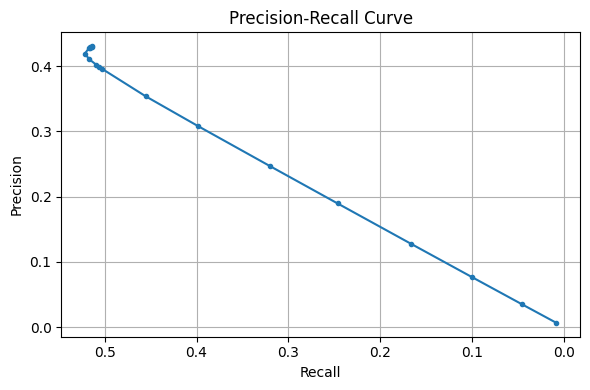

In [46]:
precision, recall = [x[1][0] for x in pr_], [x[1][1] for x in pr_]

plt.figure(figsize=(6, 4))
plt.plot(recall, precision, marker='o', markersize = 3)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.xticks(np.arange(0, 0.55, step = 0.1))
plt.gca().invert_xaxis()
plt.tight_layout()
plt.show()

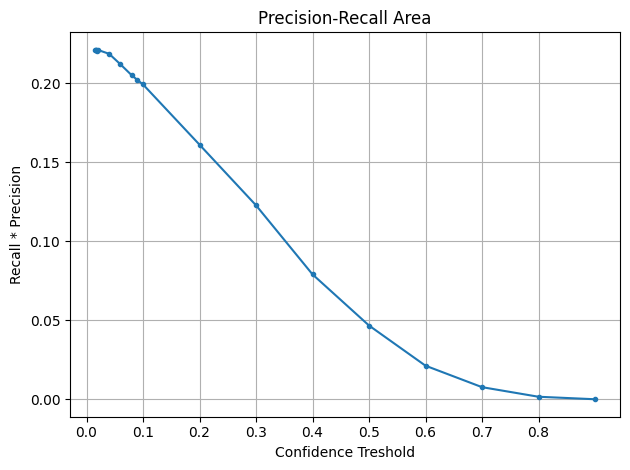

In [47]:
import matplotlib.pyplot as plt
import numpy as np
index, product = [i * 0.1 for i in range(10)], [x[1][1] * x[1][0] for x in pr_]

plt.figure()
plt.plot(threshs, product, marker='o', markersize = 3)
plt.xlabel("Confidence Treshold")
plt.ylabel("Recall * Precision")
plt.title("Precision-Recall Area")
plt.grid(True)
plt.tight_layout()
plt.xticks(np.arange(0, 0.9, step = 0.1))
plt.show()

# Training Losses

In [4]:
import util
gt_df = util.DataExtractor().croppedData()

Saving to: /workspace/mydir/obb_anns_hausarbeit/ds2_dense/ds2_dense/gt_space.json


ModelSeries: loadJsonData()
210


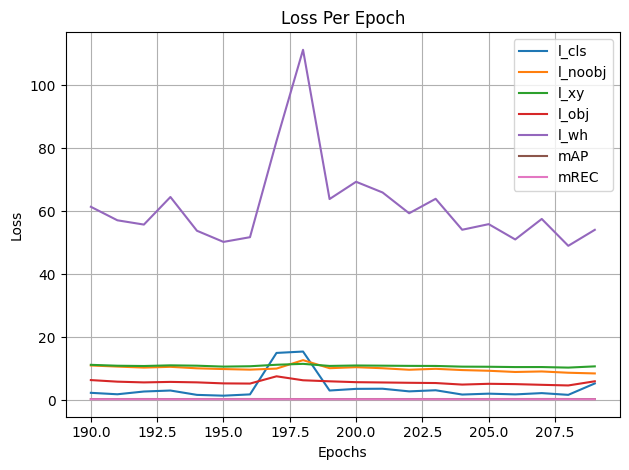

In [21]:
import ModelSeries as ms
from IPython.display import HTML, display
import matplotlib.pyplot as plt
import numpy as np
ms = ms.ModelSeries(name = "runpod_oneshot_training2", gt_df = gt_df, mode="")
records = ms.records.iloc[:]
print(len(records))
#display(HTML(records[:].to_html()))

labels =  "l_cls, l_noobj, l_xy, l_obj, l_wh, mAP, mREC".split(", ")
losses = [records[k] for k in labels]
epochs = list(range(len(losses[0])))

cutoff = 190

# plt.figure()
for loss, label in zip(losses, labels):
    # if label == "mAP":
    #     loss = [x * 100 for x in loss]
    plt.plot(epochs[cutoff:], loss[cutoff:], label = label)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Per Epoch")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()